# Variational Autoencoder Tutorial on the Wine Dataset

This notebook accompanies the written tutorial and demonstrates how to:

- Load and preprocess the Wine dataset.
- Implement a simple Variational Autoencoder (VAE) in Keras.
- Train the VAE for non-linear dimensionality reduction.
- Visualise the learned 2‑D latent space and compare it with PCA.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


TensorFlow version: 2.19.0


## 1. Load and preprocess the Wine dataset

In [ ]:
# Load wine dataset as a pandas DataFrame
wine = load_wine(as_frame=True)
df = wine.frame.copy()

X = df.drop(columns=["target"]).values.astype("float32")
y = df["target"].values

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype("float32")

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape

((142, 13), (36, 13))

## 2. Define the VAE architecture

In [ ]:
input_dim = X_train.shape[1]
latent_dim = 2  # 2D latent space for visualisation
beta = 1.0      # weight for KL term (beta-VAE)

# Encoder
inputs = keras.Input(shape=(input_dim,), name="encoder_input")
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterisation trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        448 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,044 (4.08 KB)

 Trainable params: 1,044 (4.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(input_dim, name="decoder_output")(x)

decoder = keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021 (3.99 KB)

 Trainable params: 1,021 (3.99 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Custom VAE model with ELBO loss

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss (MSE per sample)
            mse = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            # KL divergence term
            kl = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = mse + self.beta * kl

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(mse)
        self.kl_loss_tracker.update_state(kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mse = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
        kl = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = mse + self.beta * kl

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(mse)
        self.kl_loss_tracker.update_state(kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder, beta=beta)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

## 4. Train the VAE

In [ ]:
history = vae.fit(
    X_train,
    X_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, X_val),
    verbose=2,
)

Epoch 1/200
5/5 - 3s - 592ms/step - kl_loss: 0.4381 - loss: 13.7014 - reconstruction_loss: 13.2632 - val_kl_loss: 0.2967 - val_loss: 15.7247 - val_reconstruction_loss: 15.4280
Epoch 2/200
5/5 - 0s - 30ms/step - kl_loss: 0.3234 - loss: 13.7536 - reconstruction_loss: 13.4302 - val_kl_loss: 0.2097 - val_loss: 16.4255 - val_reconstruction_loss: 16.2157
Epoch 3/200
5/5 - 0s - 63ms/step - kl_loss: 0.2606 - loss: 13.5118 - reconstruction_loss: 13.2512 - val_kl_loss: 0.1542 - val_loss: 16.1742 - val_reconstruction_loss: 16.0200
Epoch 4/200
5/5 - 0s - 66ms/step - kl_loss: 0.1923 - loss: 13.3991 - reconstruction_loss: 13.2068 - val_kl_loss: 0.1230 - val_loss: 15.8351 - val_reconstruction_loss: 15.7121
Epoch 5/200
5/5 - 0s - 30ms/step - kl_loss: 0.1503 - loss: 13.0042 - reconstruction_loss: 12.8538 - val_kl_loss: 0.1063 - val_loss: 15.2559 - val_reconstruction_loss: 15.1497
Epoch 6/200
5/5 - 0s - 62ms/step - kl_loss: 0.1306 - loss: 12.8770 - reconstruction_loss: 12.7464 - val_kl_loss: 0.0974 - va

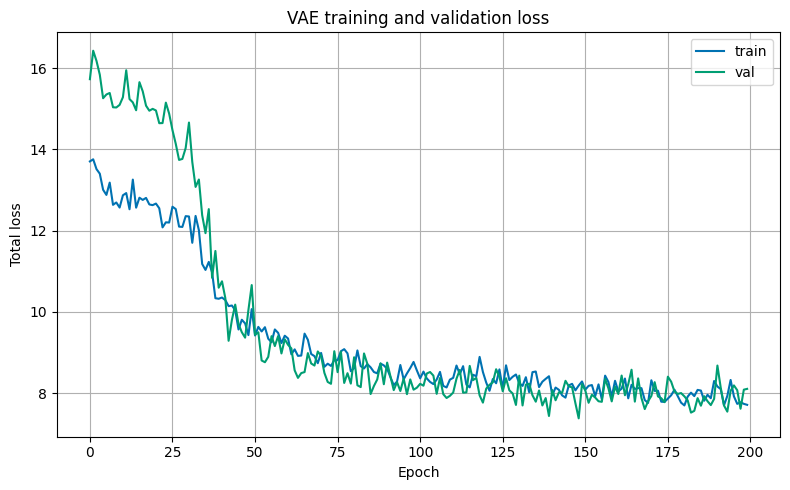

Figure: Total loss curves over training epochs for train and validation sets.


In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Total loss")
plt.title("VAE training and validation loss")
plt.legend()
plt.tight_layout()
plt.show()

print("Figure: Total loss curves over training epochs for train and validation sets.")

## 5. Visualise the 2‑D latent space

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


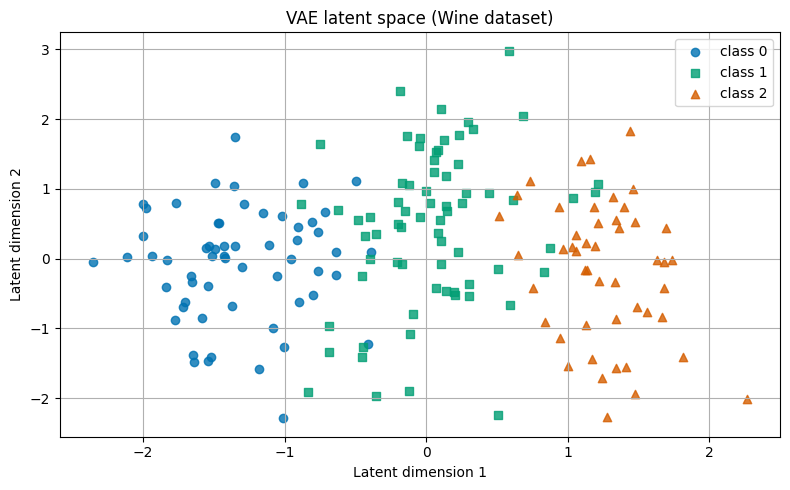

Figure: 2‑D latent representation learned by the VAE, with classes indicated by marker shape and legend.


In [ ]:
# Encode full dataset
z_mean_all, z_log_var_all, z_all = encoder.predict(X_scaled)

markers = ["o", "s", "^"]
plt.figure()
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(
        z_all[idx, 0],
        z_all[idx, 1],
        marker=markers[int(cls) % len(markers)],
        label=f"class {cls}",
        alpha=0.8,
    )
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("VAE latent space (Wine dataset)")
plt.legend()
plt.tight_layout()
plt.show()

print("Figure: 2‑D latent representation learned by the VAE, with classes indicated by marker shape and legend.")

## 6. Reconstruction error analysis

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


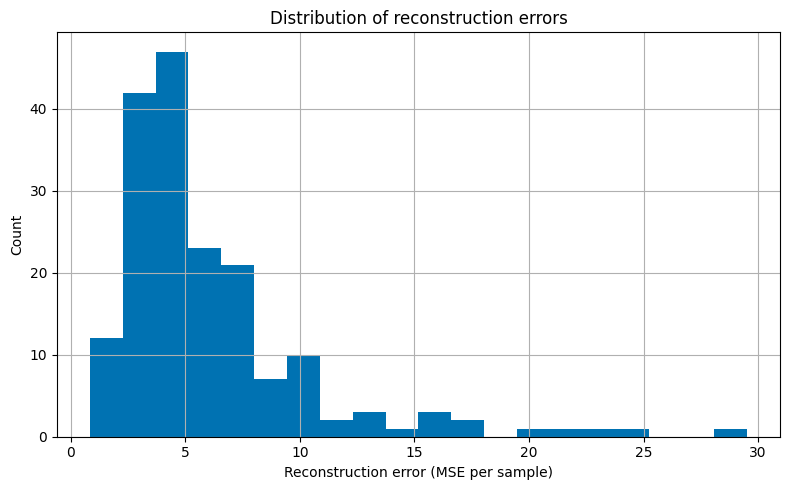

Figure: Histogram of per-sample reconstruction errors, useful for identifying potential outliers.


In [ ]:
# Reconstruction error for each sample
recon_all = decoder.predict(z_all)
recon_errors = np.sum(np.square(X_scaled - recon_all), axis=1)

plt.figure()
plt.hist(recon_errors, bins=20)
plt.xlabel("Reconstruction error (MSE per sample)")
plt.ylabel("Count")
plt.title("Distribution of reconstruction errors")
plt.tight_layout()
plt.show()

print("Figure: Histogram of per-sample reconstruction errors, useful for identifying potential outliers.")

## 7. Comparison with PCA (2‑D projection)

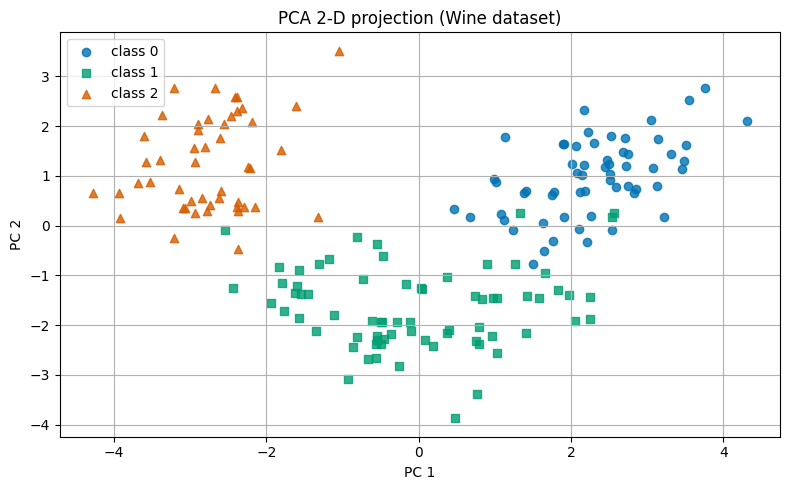

Figure: 2‑D PCA projection of the Wine dataset, for comparison with the VAE latent space.


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        marker=markers[int(cls) % len(markers)],
        label=f"class {cls}",
        alpha=0.8,
    )
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA 2‑D projection (Wine dataset)")
plt.legend()
plt.tight_layout()
plt.show()

print("Figure: 2‑D PCA projection of the Wine dataset, for comparison with the VAE latent space.")

## 8. Sampling synthetic wine feature vectors

In [ ]:
# Sample random points from the prior and decode
num_samples = 5
z_samples = np.random.normal(size=(num_samples, latent_dim)).astype("float32")
x_decoded = decoder.predict(z_samples)

# Inverse transform to original feature scale
x_decoded_original_scale = scaler.inverse_transform(x_decoded)

decoded_df = pd.DataFrame(
    x_decoded_original_scale, columns=wine.feature_names
)
decoded_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,12.393307,2.092419,2.153019,19.226368,88.407555,1.867322,1.425426,0.409402,1.195531,3.166718,1.009305,2.457959,496.839447
1,12.976425,3.211925,2.375177,20.972641,95.694183,1.602679,0.823616,0.466801,1.086362,6.463175,0.722167,1.804100,577.782166
2,12.544143,2.664304,2.504565,22.415037,104.774353,2.403834,2.255416,0.349954,1.939613,4.170411,0.945824,2.799823,593.183838
3,13.701968,2.017560,2.506118,18.318691,113.532692,2.935950,3.087281,0.288534,2.053874,5.218946,1.062045,3.292941,1181.391968
4,14.407767,1.882437,2.433168,14.395885,109.904289,3.151772,3.255796,0.275928,2.060937,7.303878,1.072085,3.104015,1311.365112


## 9. VAE loss breakdown: reconstruction vs KL divergence

The VAE optimises a composite objective

\[
\mathcal{L} = \mathbb{E}_{q_\phi(z \mid x)}[\lVert x - \hat x \rVert^2] + \beta \cdot D_{\mathrm{KL}}\left(q_\phi(z \mid x) \Vert p(z)\right),
\]

where the first term is the **reconstruction loss** and the second term is the **KL divergence** to the
standard normal prior. Plotting these components separately for both the training and validation sets
helps to understand whether the model is learning a well-structured latent space or overfitting.


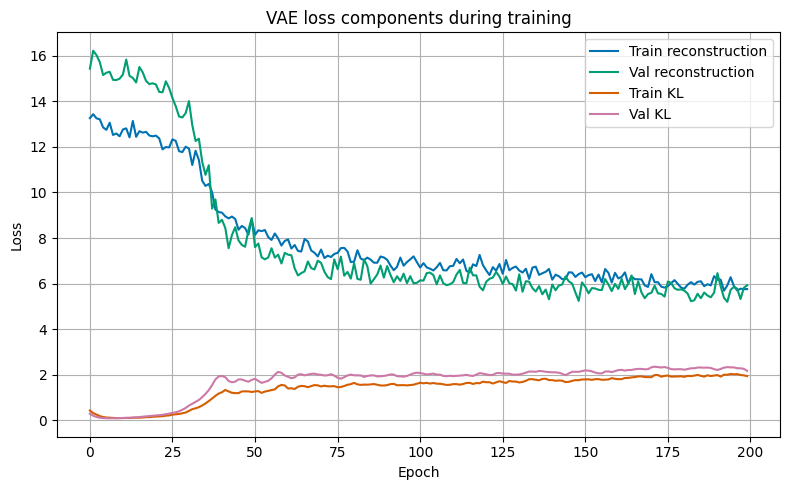

Figure: Reconstruction and KL divergence losses for training and validation sets over epochs.


In [ ]:
# Plot reconstruction and KL divergence losses for train and validation
plt.figure()
plt.plot(history.history["reconstruction_loss"], label="Train reconstruction")
plt.plot(history.history["val_reconstruction_loss"], label="Val reconstruction")
plt.plot(history.history["kl_loss"], label="Train KL")
plt.plot(history.history["val_kl_loss"], label="Val KL")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE loss components during training")
plt.legend()
plt.tight_layout()
plt.show()

print("Figure: Reconstruction and KL divergence losses for training and validation sets over epochs.")


## 10. Example reconstructions: original vs reconstructed samples

To qualitatively assess reconstruction quality, we can compare a mini-batch of original feature vectors
with their reconstructions. Each row in the heatmaps below corresponds to a sample, and each column is one
of the 13 physicochemical wine features.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


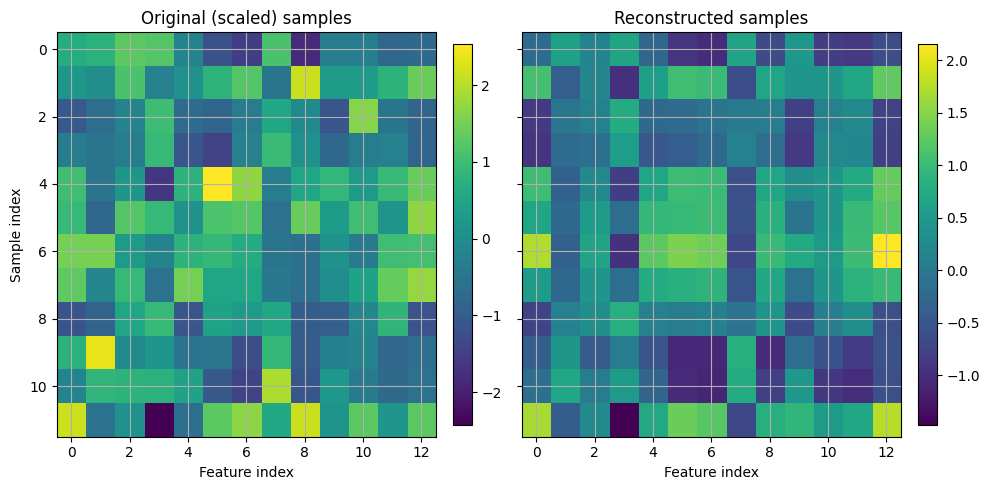

Figure: Original vs reconstructed scaled feature vectors for a random subset of wines.


In [ ]:
# Sample a small batch of wine examples
n_samples = 12
rng = np.random.default_rng(0)
idx = rng.choice(len(X_scaled), n_samples, replace=False)
x_batch = X_scaled[idx]

# Encode and decode the batch
z_mean_batch, z_log_var_batch, z_batch = encoder.predict(x_batch)
x_recon_batch = decoder.predict(z_batch)

# Plot as heatmaps: original vs reconstructed
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

im0 = axes[0].imshow(x_batch, aspect="auto")
axes[0].set_title("Original (scaled) samples")
axes[0].set_xlabel("Feature index")
axes[0].set_ylabel("Sample index")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(x_recon_batch, aspect="auto")
axes[1].set_title("Reconstructed samples")
axes[1].set_xlabel("Feature index")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("Figure: Original vs reconstructed scaled feature vectors for a random subset of wines.")


## 11. Latent space traversal

Because the VAE learns a continuous latent space, interpolating in latent space should produce smooth and
semantically meaningful changes in the decoded feature vectors. Here we construct a 2-D grid of latent
coordinates, decode each point, and visualise the resulting feature vectors as a heatmap.


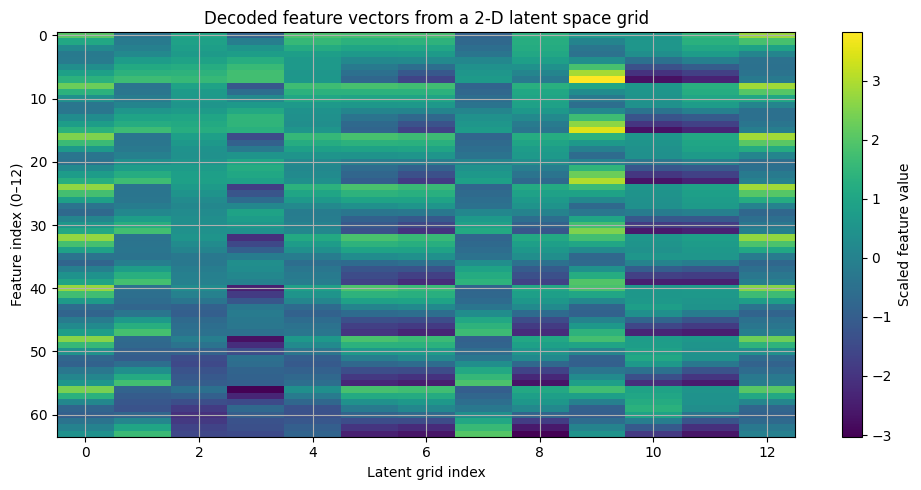

Figure: Traversal of the 2-D latent space; each column corresponds to a grid point decoded back to wine features.


In [ ]:
# Define a grid in the 2-D latent space
grid_x = np.linspace(-3.0, 3.0, 8)
grid_y = np.linspace(-3.0, 3.0, 8)

decoded_vectors = []
for yi in grid_y:
    for xi in grid_x:
        z_sample = np.array([[xi, yi]], dtype="float32")
        x_decoded = decoder.predict(z_sample, verbose=0)[0]
        decoded_vectors.append(x_decoded)

decoded_vectors = np.array(decoded_vectors)

plt.figure(figsize=(10, 5))
plt.imshow(decoded_vectors, aspect="auto")
plt.colorbar(label="Scaled feature value")
plt.xlabel("Latent grid index")
plt.ylabel("Feature index (0–12)")
plt.title("Decoded feature vectors from a 2-D latent space grid")
plt.tight_layout()
plt.show()

print("Figure: Traversal of the 2-D latent space; each column corresponds to a grid point decoded back to wine features.")


## 12. Notes on accessibility and reuse

- All plots use a colour-blind friendly Matplotlib style.
- Legends, axis labels and titles are provided so that figures remain interpretable when printed in greyscale.
- The notebook is structured into numbered sections so that individual steps can be followed with a screen reader.
- Code cells that generate figures print a one-line caption describing what the figure shows.
